# `Материалы кафедры ММП факультета ВМК МГУ. Введение в Эффективные Системы Глубокого Обучение.`

# `Семинар 06.1. Граф вычислений с точки зрения эффективности: методы оптимизации`

### `Материалы составил Феоктистов Дмитрий (@trandelik)`

#### `Москва, Осенний семестр 2025`

О чём можно узнать из этого ноутбука:

* Сколько памяти требует стандартный Adam
* Как использовать меньше памяти для оптимизатора
* Как вообще не использоваться backward и все равно что-то учить


### `Теория`

Современные языковые модели, такие как Llama, GPT и другие, содержат миллиарды параметров. Их обучение — это чрезвычайно ресурсоёмкая задача, и одна из главных проблем — это потребление памяти на GPU. Суммарная память, необходимая для обучения, складывается из нескольких компонентов:
1.  **Веса модели**: Сами параметры, которые мы обучаем.
2.  **Градиенты**: По одному градиенту на каждый параметр, вычисляемые на шаге `backward()`.
3.  **Состояние оптимизатора (Optimizer State)**: Внутренние переменные, которые оптимизатор хранит для каждого параметра (например, моменты в Adam).
4.  **Промежуточные активации**: Значения, которые необходимо хранить после `forward()` для вычисления градиентов.

Удивительно, но **состояние оптимизатора** часто занимает больше памяти, чем сами веса модели. Давайте разберёмся, почему так происходит, и рассмотрим три подхода к оптимизации, которые позволяют кардинально снизить потребление памяти:

#### `Adam`
Adam стал де-факто стандартом в DL благодаря своей эффективности и быстрой сходимостию.

**Формулы Adam:**

На каждом шаге $t$ для параметров $\theta$:
- Вычисляется градиент: $$g_t = \nabla_{\theta} L(\theta_{t-1})$$
- Обновляется скользящее среднее градиентов (первый момент):  $$ m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t $$
- Обновляется скользящее среднее квадратов градиентов (второй момент):\ $$ v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2 $$ 
- Происходит коррекция смещения для моментов: $$ \hat{m}_t = \frac{m_t}{1 - \beta_1^t}, \quad \hat{v}_t = \frac{v_t}{1 - \beta_2^t}$$
- Веса обновляются:   $$ \theta_t = \theta_{t-1} - \eta \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon} $$


**Расчёт памяти:**

Ключевой момент — для каждого обучаемого параметра $\theta$ Adam должен хранить два дополнительных значения:   
- $m_t$ (первый момент)
- $v_t$ (второй момент)

Обычно эти моменты хранятся в 32-битном формате с плавающей запятой (FP32), то есть по 4 байта на каждое значение, даже если модель обучается в смешанной точности (FP16/BF16).
*   **Память на 1 параметр:** 4 байта ($m_t$) + 4 байта ($v_t$) = **8 байт**.

Если мы обучаем модель с $N$ параметрами в смешанной точности (BF16, 2 байта на параметр), то суммарная память на параметры и оптимизатор составит:
*   **Веса модели**: $N \times 2$ байт
*   **Градиенты**: $N \times 2$ байт
*   **Состояние Adam**: $N \times 8$ байт
Для модели Llama 2 7B (7 миллиардов параметров) память на состояние Adam = $7 \times 10^9$ text{ параметров} $\times 8 $ байт/параметр = $56 \times 10^9$ байт = 56 ГБ. Эти 56 ГБ требуются *только* для хранения состояния оптимизатора, что делает невозможным полномасштабное обучение таких моделей на большинстве одиночных GPU. **Какое самое первое решение приходит в голову и в чем его проблема?**

#### `SGD`

 В своей базовой форме он не хранит никакого состояния. Чаще используется его версия с моментумом (SGD with Momentum).
 
 **Формула SGD с моментумом:** 
 - Вычисляется градиент: $$g_t = \nabla_{\theta} L(\theta_{t-1})$$  
 - Обновляется моментум: $$m_t = \beta m_{t-1} + g_t$$  
 - Веса обновляются: $$\theta_t = \theta_{t-1} - \eta m_t$$
 
 **Расчёт памяти:**
 - SGD с моментумом хранит только одно дополнительное значение для каждого параметра — буфер моментума $$m_t$$ 
 
Это в 2 раза меньше, чем у Adam. Однако у SGD есть недостатки: он не использует информацию о втором моменте, что делает его более чувствительным к выбору скорости обучения и масштабированию градиентов, и часто он сходится медленнее, чем Adam.

#### `GaLore`

https://arxiv.org/pdf/2403.03507

Использование первого и второго моментов полезно для стабильной и быстрой оптимизации. Как сохранить эти преимущества, но избавиться от огромных затрат памяти? Здесь на помощь приходит **GaLore (Gradient Low-Rank Projection)**.

**Идея и интуиция:** Основная идея GaLore заключается в наблюдении, что матрицы градиентов для больших слоёв нейронной сети часто имеют **низкий ранг**. Это означает, что "направления", в которых веса изменяются наиболее сильно, можно представить в виде небольшого набора базисных векторов. Вместо того чтобы хранить полные моменты для каждого параметра, GaLore предлагает проецировать градиент на это низкоранговое подпространство и выполнять обновления Adam уже в нём.

Представьте, что матрица градиентов $G \in \mathbb{R}^{m \\times n}$ может быть хорошо аппроксимирована как произведение двух меньших матриц $A \in \mathbb{R}^{m \times r}$ и $B \in \mathbb{R}^{n \times r}$, где ранг $r \ll \min(m, n)$. GaLore хранит состояние оптимизатора (моменты $m_t$ и $v_t$) не для полной матрицы $G$, а только для её низкоранговых проекций.

**Расчёт памяти:**
Для слоя с весами $W \in \mathbb{R}^{m \times n}$:
* **Adam** хранит $2 \times m \times n$ значений.   
* **GaLore** с рангом $r$ хранит состояние для проекций, размер которых $m \times r$ + $n \times r$.

Память на состояние оптимизатора для GaLore (в FP32): $m \cdot r$ + $n \cdot r \times 8$ байт.

Фактор экономии памяти по сравнению с Adam $\approx \frac{m \cdot n}{r \cdot (m+n)}$. Для квадратной матрицы $m=$ экономия составляет $\frac{n^2}{2nr} = \frac{n}{2r}$. Если $n=4096$ и $r=128$, то экономия будет $\frac{4096}{2 \times 128} = 16$ раз! GaLore позволяет использовать адаптивность Adam, но со сложностью по памяти, близкой к линейной $O(n)$ вместо квадратичной $O(n^2)$ для матриц весов.

**Замечание:** У GaLore есть один существенный минус - необходимость считать SVD. Также он иногда оказывается субоптимальным по качеству работы, в области оптимизации с уменьшенным стейтом есть более интересные результаты, например, [FRUGAL](https://arxiv.org/pdf/2411.07837). 

#### `MeZO`

Помимо стейта оптимизатора много памяти занимают **активации**, необходимые для вычисления градиентов. А что, если мы можем вообще отказаться от вычисления градиентов через backpropagation? Этот радикальный подход называется **оптимизацией нулевого порядка (Zeroth-Order Optimization)**. Рассмотрим **MeZO (Memory-Efficient Zeroth-Order Optimizer)**.

**Идея и интуиция:** Вместо вычисления точного градиента $\nabla L(\theta)$ (что требует `backward()`), мы будем его приблизительно оценивать просто наблюдая за изменением функции потерь $L$ при небольшом случайном возмущении параметров $\theta$.

**Формулы для приближения градиента:** MeZO использует симметричную разность для оценки градиента. 

- Генерируется случайный вектор $z$ из стандартного нормального распределения, имеющий ту же размерность, что и параметры $\theta$.
- Выполняются два `forward`-прохода с параметрами, сдвинутыми в противоположные стороны вдоль направления $z$: $L(\theta + \mu z)$, $L(\theta - \mu z)$, где $\mu$ — это очень маленькая константа (шаг возмущения). 
- Градиент оценивается по следующей формуле: $$\hat{g} = \frac{L(\theta + \mu z) - L(\theta - \mu z)}{2\mu}$$

**Почему это работает?**  Выражение $\frac{L(\theta + \mu z) - L(\theta - \mu z)}{2\mu}$ является аппроксимацией производной функции $L$ по направлению $z$. Умножая этот скаляр на вектор направления $z$, мы получаем случайную оценку градиента. Математически можно показать, что математическое ожидание этой оценки равно истинному градиенту: $\mathbb{E}[\hat{g}] = \nabla L(\theta)$. Несмотря на "шумность" такой оценки на каждом отдельном шаге, в среднем за множество итераций модель движется в правильном направлении — в сторону уменьшения потерь. **Главное преимущество MeZO** — колоссальная экономия памяти. Поскольку `backward()` не вызывается, нет необходимости хранить промежуточные активации для их вычисления. Это позволяет проводить fine-tuning огромных моделей на устройствах с очень ограниченным объёмом VRAM.

**Замечания**
- MeZO является хорошим, но не самым лучшим ZO-методом. Можно посмотреть, например, на [Jaguar Sign-SGD](https://arxiv.org/pdf/2506.04430)
- Методы нулевого порядка весьма капризны с точки зрения сходимости. Например, ими тяжело обучать случайно инициализированные веса. С этой точки зрения может сильно помочь использование оценки градиента не по одному направлению $z$, а по нескольким, однако, это приведет к увеличению расхода памяти. Но в случае, например, SFT LLM на свои данные они могут быть очень даже неплохи.

### `Практика`

В ней мы будем файнтюнить distilbert на IMDB датасет. Сравним качество, потребляемую память и время работы следующих методов:

- `AdamW`
- `SGD`
- `GaLore`
- `MeZO`

Поскольку IMDB это задача классификации, и мы будем менять голову нашей модели, то для `MeZO` мы будем доучивать то, что до этого обучили через `SGD`

#### `Utils`

In [2]:
import gc
import math
import os
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

from datasets import load_dataset
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    set_seed,
)

# Set the visible CUDA device (optional, for multi-GPU systems)
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_CKPT = "distilbert-base-uncased"
NUM_EPOCHS_GRADIENT = 1
BATCH_SIZE = 16
RANDOM_SEED = 42

print(f"Running on device: {DEVICE}")

Running on device: cuda


In [3]:
def get_peak_memory(device=DEVICE):
    """Gets the peak memory usage in MB."""
    if device.type == 'cuda':
        return torch.cuda.max_memory_allocated() / (1024 * 1024)
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / (1024 * 1024)

def clean_memory(device=DEVICE):
    """Cleans GPU cache and resets memory stats."""
    gc.collect()
    if device.type == 'cuda':
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()

def get_model(device=DEVICE):
    """Initializes a new model and moves it to the specified device."""
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_CKPT, num_labels=2
    )
    return model.to(device)

# --- Dataset and Dataloader Setup ---
print("Setting up dataset...")
raw_datasets = load_dataset("imdb")
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=256)

tokenized_datasets = raw_datasets.map(
    tokenize_function, batched=True
).remove_columns(["text"]).rename_column(
    "label", "labels"
).with_format("torch")

# Create smaller, manageable subsets for the experiment
small_train_dataset = tokenized_datasets["train"].shuffle(seed=RANDOM_SEED).select(range(4000))
small_test_dataset = tokenized_datasets["test"].shuffle(seed=RANDOM_SEED).select(range(800))

# Create DataLoaders
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_loader = DataLoader(
    small_train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=data_collator
)
test_loader = DataLoader(
    small_test_dataset, batch_size=BATCH_SIZE, collate_fn=data_collator
)
print("Setup complete.")

Setting up dataset...


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Setup complete.


#### `GaLore`

In [4]:
class GaLoreAdamW(optim.Optimizer):
    """Implements the GaLore-AdamW optimizer."""
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=1e-2, rank=128):
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, rank=rank)
        super(GaLoreAdamW, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step."""
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad
                state = self.state[p]
                rank = group['rank']

                # Apply weight decay
                if group['weight_decay'] != 0:
                    p.data.add_(p.data, alpha=-group['weight_decay'] * group['lr'])

                # Determine if this parameter qualifies for GaLore
                is_large_2d = (grad.dim() == 2 and grad.shape[0] > rank
                               and grad.shape[1] > rank)

                if is_large_2d:
                    u, s, vh = torch.linalg.svd(grad, full_matrices=False)
                    u, s, vh = u[:, :rank], s[:rank], vh[:rank, :]
                    grad_u = u @ torch.diag(s)
                    grad_v = vh.T

                    # Initialize optimizer states for U and V
                    if 'exp_avg_U' not in state:
                        state['step'] = 0
                        state['exp_avg_U'] = torch.zeros_like(grad_u)
                        state['exp_avg_sq_U'] = torch.zeros_like(grad_u)
                        state['exp_avg_V'] = torch.zeros_like(grad_v)
                        state['exp_avg_sq_V'] = torch.zeros_like(grad_v)

                    state['step'] += 1
                    beta1, beta2 = group['betas']

                    # Update low-rank factors using AdamW logic
                    for factors in [(grad_u, 'exp_avg_U', 'exp_avg_sq_U'),
                                    (grad_v, 'exp_avg_V', 'exp_avg_sq_V')]:
                        G, M, V = factors
                        state[M].mul_(beta1).add_(G, alpha=1 - beta1)
                        state[V].mul_(beta2).addcmul_(G, G, value=1 - beta2)

                        bias_correction1 = 1 - beta1 ** state['step']
                        bias_correction2 = 1 - beta2 ** state['step']

                        denom = (state[V].sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])
                        update_factor = state[M] / bias_correction1

                        if G is grad_u:
                            update_u = update_factor / denom
                        else:
                            update_v = update_factor / denom
                    
                    # Reconstruct the full update and apply it
                    p.add_((update_u @ update_v.T), alpha=-group['lr'])

                else:
                    if 'exp_avg' not in state:
                        state['step'] = 0
                        state['exp_avg'] = torch.zeros_like(p.data)
                        state['exp_avg_sq'] = torch.zeros_like(p.data)

                    state['step'] += 1
                    beta1, beta2 = group['betas']

                    state['exp_avg'].mul_(beta1).add_(grad, alpha=1 - beta1)
                    state['exp_avg_sq'].mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                    bias_correction1 = 1 - beta1 ** state['step']
                    bias_correction2 = 1 - beta2 ** state['step']
                    denom = (state['exp_avg_sq'].sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])
                    step_size = group['lr'] / bias_correction1
                    
                    p.addcdiv_(state['exp_avg'], denom, value=-step_size)


#### `Обучение с помощью MeZO`

In [5]:
def train_one_epoch_mezo(model, loader, lr=1e-4, sigma=1e-5, device=DEVICE):
    """Trains the model for one epoch using the MeZO algorithm."""
    model.train()
    total_loss = 0
    
    for batch in tqdm(loader, desc="MeZO Finetuning"):
        batch = {k: v.to(device) for k, v in batch.items()}
        
        with torch.no_grad():
            # 1. Store original parameters and calculate original loss
            original_params = [p.clone() for p in model.parameters()]
            outputs_orig = model(**batch)
            loss_orig = outputs_orig.loss

            # 2. Create a random perturbation vector
            perturbation = [torch.randn_like(p) for p in model.parameters()]

            # 3. Calculate loss with positive perturbation
            for p, p_pert in zip(model.parameters(), perturbation):
                p.data.add_(p_pert, alpha=sigma)
            outputs_pert_plus = model(**batch)
            loss_pert_plus = outputs_pert_plus.loss

            # 4. Calculate loss with negative perturbation
            for p, p_pert in zip(model.parameters(), perturbation):
                p.data.add_(p_pert, alpha=-2 * sigma)
            outputs_pert_minus = model(**batch)
            loss_pert_minus = outputs_pert_minus.loss

            # 5. Estimate the projected gradient
            # Add a small epsilon to avoid division by zero
            projected_grad = (loss_pert_plus - loss_pert_minus) / (2 * sigma + 1e-9)

            # 6. Reset to original parameters and apply the ZO update
            for i, p in enumerate(model.parameters()):
                p.data = original_params[i]
                p.data.add_(perturbation[i], alpha=-lr * projected_grad)
                
        total_loss += loss_orig.item()
        
    return total_loss / len(loader)

#### `Обучени градиентными методами, валидация`

In [6]:
def evaluate(model, loader, device=DEVICE):
    """Evaluates the model's accuracy on a given data loader."""
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            predictions = torch.argmax(outputs.logits, dim=-1)
            total += batch["labels"].size(0)
            correct += (predictions == batch["labels"]).sum().item()
    return 100 * correct / total


def run_gradient_experiment(method_name, optimizer_class, optimizer_params):
    """
    Runs a full training and evaluation experiment for a gradient-based optimizer.
    
    Returns:
        A tuple containing:
        - result (dict): A dictionary with the method name, accuracy, and memory usage.
        - final_state_dict (dict or None): The model's state dictionary after training.
          This is only returned for the 'SGD' method to pass to MeZO.
    """
    set_seed(RANDOM_SEED)
    print(f"\n--- Running Experiment: {method_name} ---")
    clean_memory()
    
    model = get_model()
    optimizer = optimizer_class(model.parameters(), **optimizer_params)
    print(f"Memory after setup: {get_peak_memory():.2f} MB")

    for epoch in range(NUM_EPOCHS_GRADIENT):
        model.train()
        total_loss = 0
        pbar = tqdm(train_loader, desc=f"Training {method_name}")
        for batch in pbar:
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            optimizer.zero_grad()
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            pbar.set_postfix(loss=loss.item())
            
        train_loss = total_loss / len(train_loader)
        accuracy = evaluate(model, test_loader)
        print(f"Epoch {epoch + 1}/{NUM_EPOCHS_GRADIENT} -> Loss: {train_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

    final_accuracy = evaluate(model, test_loader)
    peak_memory = get_peak_memory()
    print(f"\nFinal Accuracy ({method_name}): {final_accuracy:.2f}%")
    print(f"Peak Memory Usage ({method_name}): {peak_memory:.2f} MB")

    result = {
        'Method': method_name,
        'Accuracy (%)': final_accuracy,
        'Peak Memory (MB)': peak_memory
    }
    
    final_state_dict = None
    if method_name == 'SGD':
        final_state_dict = deepcopy(model.cpu().state_dict())

    del model, optimizer
    clean_memory()
    
    return result, final_state_dict

#### `Запустим градиентные методы`

In [11]:
all_results = []
sgd_final_state_dict = None

# # --- Experiment 1: AdamW (Baseline) ---
adamw_result, _ = run_gradient_experiment(
    method_name='AdamW',
    optimizer_class=optim.AdamW,
    optimizer_params={'lr': 2e-5, 'weight_decay': 0.01}
)
if adamw_result:
    all_results.append(adamw_result)

# # --- Experiment 2: SGD (and save state for MeZO) ---
sgd_result, sgd_final_state_dict = run_gradient_experiment(
    method_name='SGD',
    optimizer_class=optim.SGD,
    optimizer_params={'lr': 5e-4, 'momentum': 0.9}
)
if sgd_result:
    all_results.append(sgd_result)

# --- Experiment 3: GaLore-AdamW ---
galore_result, _ = run_gradient_experiment(
    method_name='GaLore-AdamW',
    optimizer_class=GaLoreAdamW,
    optimizer_params={'lr': 1e-4, 'rank': 128, 'weight_decay': 0.01}
)
if galore_result:
    all_results.append(galore_result)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Running Experiment: GaLore-AdamW ---
Memory after setup: 272.87 MB


Training GaLore-AdamW:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1/1 -> Loss: 0.4763, Test Accuracy: 84.75%

Final Accuracy (GaLore-AdamW): 84.75%
Peak Memory Usage (GaLore-AdamW): 1678.70 MB


#### `Запустим MeZO, инициализированный моделью, полученной SGD`

In [8]:
def run_mezo_experiment(initial_state_dict, num_epochs):
    """
    Runs the MeZO finetuning experiment, starting from a given model state.
    
    Returns:
        A dictionary with the method name, accuracy, and memory usage, or None on failure.
    """
    set_seed(RANDOM_SEED)
    method_name = 'MeZO (from SGD)'
    print(f"\n--- Running Experiment: {method_name} ---")
    clean_memory()
    
    if initial_state_dict is None:
        print("ERROR: An initial state dictionary must be provided for MeZO tuning.")
        return None

    model = get_model()
    model.load_state_dict(initial_state_dict)
    model.to(DEVICE)
        
    print(f"Memory after loading finetuned model: {get_peak_memory():.2f} MB")
    
    start_accuracy = evaluate(model, test_loader)
    print(f"Accuracy before MeZO tuning: {start_accuracy:.2f}%")

    for epoch in range(num_epochs):
        train_loss = train_one_epoch_mezo(model, train_loader, lr=1e-6, sigma=1e-3)
        accuracy = evaluate(model, test_loader)
        print(f"Epoch {epoch + 1}/{num_epochs} -> Loss: {train_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

    final_accuracy = evaluate(model, test_loader)
    peak_memory = get_peak_memory()
    
    print(f"\nFinal Accuracy ({method_name}): {final_accuracy:.2f}%")
    print(f"Peak Memory Usage ({method_name}): {peak_memory:.2f} MB")
    
    result = {
        'Method': method_name,
        'Accuracy (%)': final_accuracy,
        'Peak Memory (MB)': peak_memory
    }
    
    del model
    clean_memory()
    
    return result

In [9]:
mezo_result = run_mezo_experiment(
    initial_state_dict=sgd_final_state_dict,
    num_epochs=5
)
if mezo_result:
    all_results.append(mezo_result)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Running Experiment: MeZO (from SGD) ---
Memory after loading finetuned model: 272.87 MB
Accuracy before MeZO tuning: 80.38%


MeZO Finetuning:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1/5 -> Loss: 0.4298, Test Accuracy: 80.38%


MeZO Finetuning:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 2/5 -> Loss: 0.4244, Test Accuracy: 80.88%


MeZO Finetuning:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3/5 -> Loss: 0.4161, Test Accuracy: 82.62%


MeZO Finetuning:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4/5 -> Loss: 0.4123, Test Accuracy: 82.75%


MeZO Finetuning:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5/5 -> Loss: 0.4077, Test Accuracy: 83.25%

Final Accuracy (MeZO (from SGD)): 83.25%
Peak Memory Usage (MeZO (from SGD)): 1059.92 MB


### `Сравнение результатов`

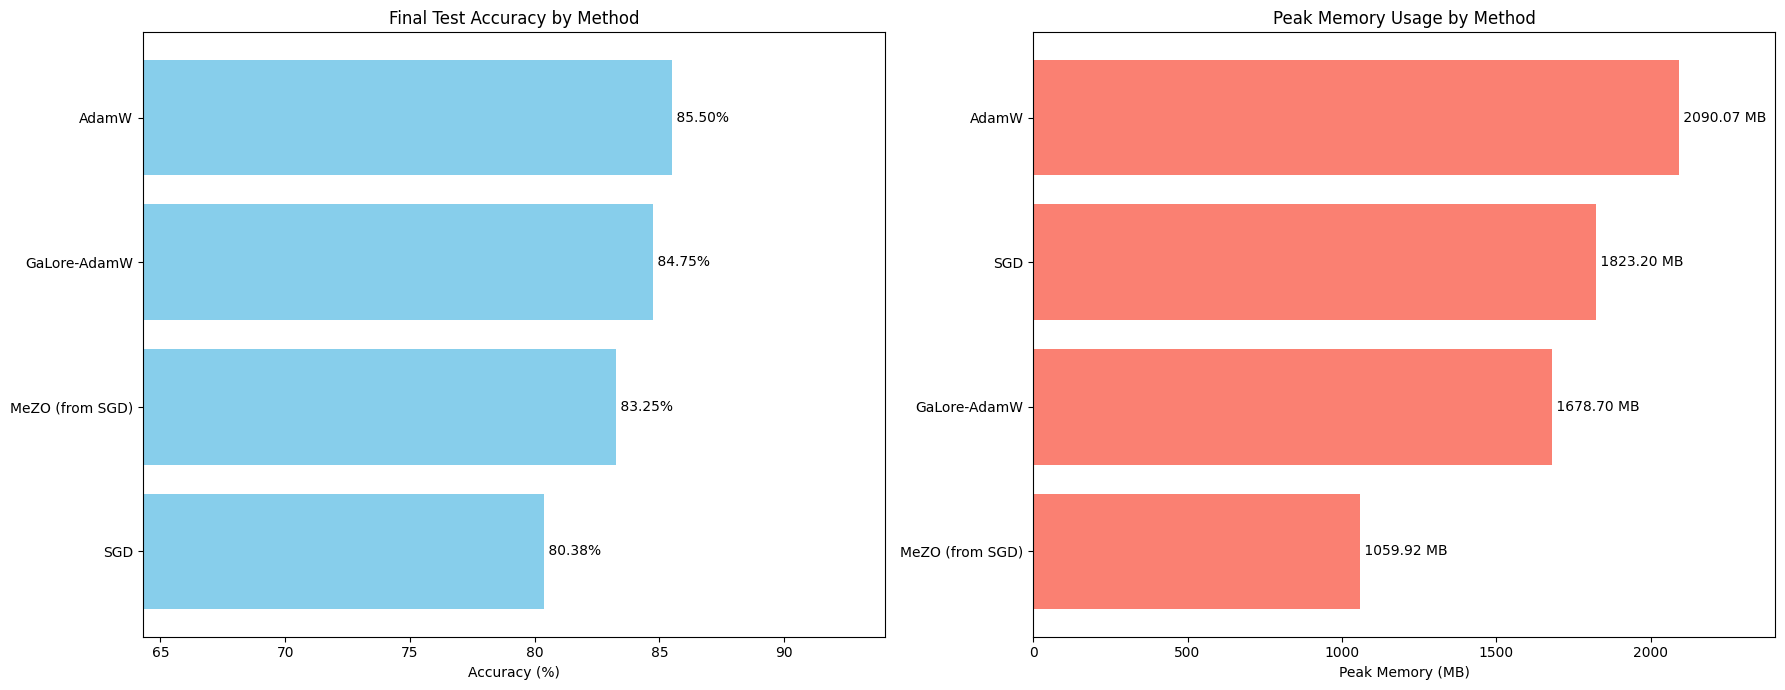

In [12]:
df_results = pd.DataFrame(all_results)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

df_sorted_acc = df_results.sort_values('Accuracy (%)')
ax1.barh(df_sorted_acc['Method'], df_sorted_acc['Accuracy (%)'], color='skyblue')
ax1.set_title('Final Test Accuracy by Method')
ax1.set_xlabel('Accuracy (%)')

for index, value in enumerate(df_sorted_acc['Accuracy (%)']):
    ax1.text(value, index, f' {value:.2f}%', va='center', ha='left')
ax1.set_xlim(min(df_results['Accuracy (%)']) * 0.8, 
           max(df_results['Accuracy (%)']) * 1.1)

df_sorted_mem = df_results.sort_values('Peak Memory (MB)')
ax2.barh(df_sorted_mem['Method'], df_sorted_mem['Peak Memory (MB)'], color='salmon')
ax2.set_title('Peak Memory Usage by Method')
ax2.set_xlabel('Peak Memory (MB)')

for index, value in enumerate(df_sorted_mem['Peak Memory (MB)']):
    ax2.text(value, index, f' {value:.2f} MB', va='center', ha='left')
ax2.set_xlim(0, max(df_results['Peak Memory (MB)']) * 1.15)

fig.tight_layout()
plt.show()